<a href="https://colab.research.google.com/github/silverkkang/DL/blob/main/1%EC%B0%A8BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas scikit-learn
!pip install transformers torch
!pip install scikit-learn matplotlib
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import re
import pickle
import os
from datetime import datetime
from sklearn.model_selection import train_test_split

In [5]:
file_name = '/content/drive/MyDrive/Clustering/진짜 최종종합본.csv'
df = pd.read_csv(file_name, engine='python', on_bad_lines='skip')

In [6]:
print(df.head(3))

   Unnamed: 0                                 title  \
0           0          소음순 돌출 되어 불편함 겪어보신 분 계실까요..?   
1           1                        임부복 바지 도와주세요 ㅠ   
2           2  모유수유 분유 상관 없이 수유쿠션은 쓰나요? 둘중 뭐가 편할까요!   

                                            contents  \
0  지금 임신 5주차예요 ~예전에 산부인과에서 검사하면서소음순이 비대칭이네 라고 원장님...   
1  스토퍼형 하나사봤는데 조이면 조인곳이 너무 불편하고안조이면 흘러내리고 ㅜ원피스 사긴...   
2         가격 상관 없이 뭐가 나아보이나요?수유 어떻게 할지 모르겠는데 잘쓸까요,,?   

                                                 url        date  nouns  
0  https://cafe.naver.com/f-e/cafes/10094499/arti...  2025-11-15    NaN  
1  https://cafe.naver.com/f-e/cafes/10094499/arti...  2025-11-15    NaN  
2  https://cafe.naver.com/f-e/cafes/10094499/arti...  2025-11-15    NaN  


# Step1. 전처리


In [7]:
TEXT_COLUMN = 'contents'
original_count = len(df)

In [8]:
#1 결측치 제거
df = df.dropna(subset=[TEXT_COLUMN])
print(f"1️⃣  결측치 제거: {original_count - len(df):,}개 → {len(df):,}개 남음")

# 빈 문자열 제거
before_count = len(df)
df = df[df[TEXT_COLUMN].str.strip() != '']
print(f"2️⃣  빈 문자열 제거: {before_count - len(df):,}개 → {len(df):,}개 남음")

# 정규표현식 정리
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<[^>]+>', '', text)  # HTML
    text = re.sub(r'http[s]?://\S+', '', text)  # URL
    text = re.sub(r'\S+@\S+', '', text)  # Email
    text = re.sub(r'([!?])\1{2,}', r'\1', text)  # 특수문자
    text = re.sub(r'(\.)\1{3,}', r'\1\1\1', text)
    text = re.sub(r'([ㅋㅎㅠㅜㅡ])\1{2,}', r'\1\1', text)  # 한글 자음
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(clean_text)
df = df[df[TEXT_COLUMN] != '']

# 중복 제거
before_count = len(df)
df = df.drop_duplicates(subset=[TEXT_COLUMN], keep='first')

# 최소 길이 필터링
MIN_LENGTH = 5
before_count = len(df)
df = df[df[TEXT_COLUMN].str.len() >= MIN_LENGTH]

df = df.reset_index(drop=True)

1️⃣  결측치 제거: 33개 → 90,160개 남음
2️⃣  빈 문자열 제거: 1개 → 90,159개 남음


In [9]:

print(f"\n전처리 완료: {original_count:,}개 → {len(df):,}개")



전처리 완료: 90,193개 → 90,104개


In [10]:
df_sampled = df.copy()
texts = df_sampled[TEXT_COLUMN].tolist()
print(f"사용할 데이터: {len(df_sampled):,}개")

사용할 데이터: 90,104개


In [11]:
save_data_step1 = {
    'df_sampled': df_sampled,
    'texts': texts,
    'TEXT_COLUMN': TEXT_COLUMN,
    'original_count': original_count,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('step1_preprocessing_result.pkl', 'wb') as f:
    pickle.dump(save_data_step1, f)

print("💾 Step 1 저장 완료")
print(f"""
저장 내용:
  - 원본 데이터: {original_count:,}개
  - 전처리 후: {len(df):,}개
  - 사용 데이터: {len(df_sampled):,}개 (전체 사용) ⭐
  - 텍스트 컬럼: {TEXT_COLUMN}
""")

💾 Step 1 저장 완료

저장 내용:
  - 원본 데이터: 90,193개
  - 전처리 후: 90,104개
  - 사용 데이터: 90,104개 (전체 사용) ⭐
  - 텍스트 컬럼: contents



# Step 2. 임베딩

In [12]:
# Step 2: 임베딩

import torch
from transformers import ElectraModel, ElectraTokenizer
from tqdm import tqdm

In [13]:
#  2결과 불러오기
with open('step1_preprocessing_result.pkl', 'rb') as f:
    step1_data = pickle.load(f)

df_sampled = step1_data['df_sampled']
TEXT_COLUMN = step1_data['TEXT_COLUMN']
texts = df_sampled[TEXT_COLUMN].tolist()

In [14]:
#모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model_name = "monologg/koelectra-base-v3-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(model_name)
model = ElectraModel.from_pretrained(model_name).to(device)
model.eval()

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(35000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

In [15]:
#2텍스트 길이 분석
sample_size = min(1000, len(texts))
text_lengths = [len(tokenizer.encode(text)) for text in texts[:sample_size]]
avg_length = np.mean(text_lengths)
p95_length = np.percentile(text_lengths, 95)

print(f"   평균: {avg_length:.0f} 토큰")
print(f"   95%: {p95_length:.0f} 토큰")

max_length = min(int(p95_length), 512)
print(f"   → max_length 설정: {max_length}")

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


   평균: 174 토큰
   95%: 564 토큰
   → max_length 설정: 512


In [16]:
#2임베딩 함수
def get_electra_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Mean Pooling
        last_hidden_states = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']

        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        mean_pooled_embeddings = sum_embeddings / sum_mask

        all_embeddings.extend(mean_pooled_embeddings.cpu().numpy())

        del inputs, outputs, last_hidden_states
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return np.array(all_embeddings)


In [17]:
#2임베딩 생성
embeddings = get_electra_embeddings(texts, batch_size=16, max_length=max_length)

Embedding: 100%|██████████| 5632/5632 [54:17<00:00,  1.73it/s]


In [18]:
#2피클 저장
save_data_step2 = {
    'embeddings': embeddings,
    'df_sampled': df_sampled,
    'texts': texts,
    'TEXT_COLUMN': TEXT_COLUMN,
    'max_length': max_length,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('step2_embeddings_result.pkl', 'wb') as f:
    pickle.dump(save_data_step2, f)

file_size = os.path.getsize('step2_embeddings_result.pkl') / (1024**2)
print(f"저장 완료: step2_embeddings_result.pkl ({file_size:.1f} MB)")
print(f"""
저장 내용:
  - 임베딩: {embeddings.shape}
  - 데이터프레임: {len(df_sampled):,}개
  - 텍스트: {len(texts):,}개
""")

저장 완료: step2_embeddings_result.pkl (502.3 MB)

저장 내용:
  - 임베딩: (90104, 768)
  - 데이터프레임: 90,104개
  - 텍스트: 90,104개



# Step 3. 클러스터링

In [19]:
#클러스터링

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [20]:
#결과 불러오기

with open('step2_embeddings_result.pkl', 'rb') as f:
    step2_data = pickle.load(f)

embeddings = step2_data['embeddings']
df_sampled = step2_data['df_sampled']
texts = step2_data['texts']
TEXT_COLUMN = step2_data['TEXT_COLUMN']

In [21]:
#최적 K 찾기
max_k = min(15, len(texts) // 100)
k_range = range(2, max_k + 1)
silhouette_scores = []

for k in tqdm(k_range, desc="Finding K"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    clusters = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

Finding K:   7%|▋         | 1/14 [06:48<1:28:36, 408.95s/it]

K=2: Silhouette Score = 0.5245


Finding K:  14%|█▍        | 2/14 [13:41<1:22:13, 411.14s/it]

K=3: Silhouette Score = 0.3433


Finding K:  21%|██▏       | 3/14 [20:35<1:15:35, 412.29s/it]

K=4: Silhouette Score = 0.2739


Finding K:  29%|██▊       | 4/14 [27:51<1:10:18, 421.81s/it]

K=5: Silhouette Score = 0.1606


Finding K:  36%|███▌      | 5/14 [35:15<1:04:26, 429.63s/it]

K=6: Silhouette Score = 0.1413


Finding K:  43%|████▎     | 6/14 [42:57<58:46, 440.85s/it]  

K=7: Silhouette Score = 0.1245


Finding K:  50%|█████     | 7/14 [50:32<51:57, 445.29s/it]

K=8: Silhouette Score = 0.1173


Finding K:  57%|█████▋    | 8/14 [58:25<45:24, 454.09s/it]

K=9: Silhouette Score = 0.1145


Finding K:  64%|██████▍   | 9/14 [1:06:33<38:44, 464.80s/it]

K=10: Silhouette Score = 0.0991


Finding K:  71%|███████▏  | 10/14 [1:14:49<31:37, 474.48s/it]

K=11: Silhouette Score = 0.0959


Finding K:  79%|███████▊  | 11/14 [1:22:59<23:57, 479.19s/it]

K=12: Silhouette Score = 0.0941


Finding K:  86%|████████▌ | 12/14 [1:31:56<16:33, 496.82s/it]

K=13: Silhouette Score = 0.0897


Finding K:  93%|█████████▎| 13/14 [1:41:21<08:37, 517.39s/it]

K=14: Silhouette Score = 0.0876


Finding K: 100%|██████████| 14/14 [1:50:41<00:00, 474.38s/it]

K=15: Silhouette Score = 0.0854


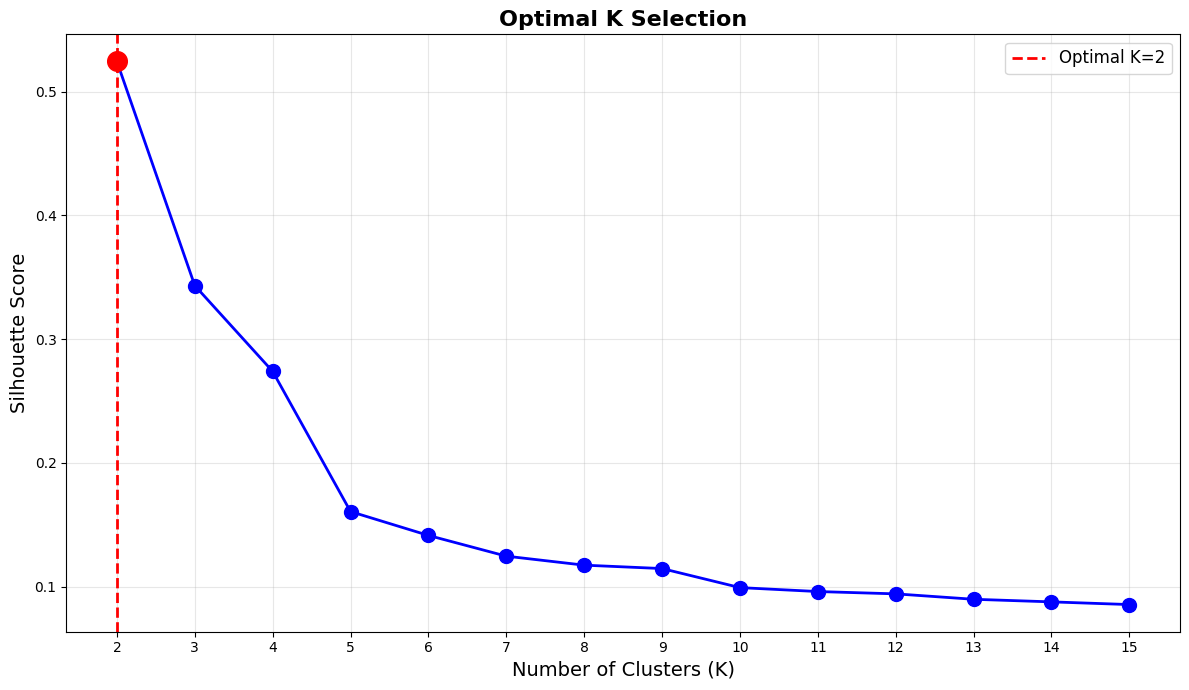


최적 K = 2 (Score: 0.5245)


In [22]:
#시각화
plt.figure(figsize=(12, 7))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Optimal K Selection', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

optimal_idx = np.argmax(silhouette_scores)
optimal_k = list(k_range)[optimal_idx]
optimal_score = silhouette_scores[optimal_idx]

plt.axvline(x=optimal_k, color='r', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
plt.scatter([optimal_k], [optimal_score], color='red', s=200, zorder=5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('optimal_k_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n최적 K = {optimal_k} (Score: {optimal_score:.4f})")

In [23]:
#최종 클러스터링
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
cluster_labels = kmeans_final.fit_predict(embeddings)

df_sampled['cluster'] = cluster_labels

In [24]:
#클러스터 통계
cluster_counts = df_sampled['cluster'].value_counts().sort_index()
for i in range(optimal_k):
    count = cluster_counts[i]
    percentage = count / len(df_sampled) * 100
    bar = "█" * int(percentage / 2)
    print(f"Cluster {i}  |  {count:5,}개  ({percentage:5.1f}%)  {bar}")
print("-" * 50)

Cluster 0  |  41,667개  ( 46.2%)  ███████████████████████
Cluster 1  |  48,437개  ( 53.8%)  ██████████████████████████
--------------------------------------------------


In [25]:
#클러스터 샘플
print("\n📝 클러스터별 샘플 (각 5개):")
for i in range(optimal_k):
    print(f"\n[Cluster {i}]")
    samples = df_sampled[df_sampled['cluster'] == i][TEXT_COLUMN].head(5).tolist()
    for idx, sample in enumerate(samples, 1):
        print(f"  {idx}. {sample[:100]}...")


📝 클러스터별 샘플 (각 5개):

[Cluster 0]
  1. 지금 임신 5주차예요 ~예전에 산부인과에서 검사하면서소음순이 비대칭이네 라고 원장님이 혼잣말 한걸 들은적 있어요저한테 물어본것도 아니고 해서 딱히 신경 안쓰고 있었는데요 간혹 속옷...
  2. 스토퍼형 하나사봤는데 조이면 조인곳이 너무 불편하고안조이면 흘러내리고 ㅜ원피스 사긴샀는데 키가작아 기장이 너무길어서 종류가 한정적이에요ㅠ유니클로 니트팬츠는 재고가 거의없네요.. 입...
  3. 가격 상관 없이 뭐가 나아보이나요?수유 어떻게 할지 모르겠는데 잘쓸까요,,?...
  4. 오늘도 출근이라 아침 7시에 일어나야 했는데..자기 전까지 뭘 먹고 잤거든요그런데도 12시 2시 4시 6시 너무 배가 고파서 깼어요위장이 꼬이면서 아픈 느낌...그리고 처음에 밥먹...
  5. 임신 4개월차 초보 맘이에요.솔직히 아기 건강 생각하면 밤에 잠도 안 와요ㅠㅠ병원비며 선천 이상 걱정에 머리가 터질 것 같았는데,이 태아보험 찾아보고 좀 안심했어요.출생 직후부터 ...

[Cluster 1]
  1. 안녕하세요. 다음 달 출산하는 경산모입니다출산 후 조리원 안가구산후도우미 약 4주 정도 쓸꺼고2주는 남편이 첫째 올케어휴가 끝나고 나머지 2주만이모님께 첫째케어 부탁드릴 예정이에요...
  2. 오늘 7주 마지막날이고 내일되면 벌써 8주인데 5-6주부터 시작된 입덧이 저를 죽도록 괴롭히네요일상생활 아예 안되고 하루에 입덧약을 3-4알 먹으니 계속 잠만자고 산부인과 진료외에...
  3. 분리수면 계획이 있어서 아기 침대를 미리 구매했어요!오늘 매트리스가 도착해서 후기 올려봐요.구매한 매트리스는 ‘엘라비아s6’이고매장에서 구매했어요!매트리스를 일룸과 엘라비에중에 고...
  4. 새벽에 깨어나 백일된 아기 수유하고, 누워서 자려고 했는데 방금 꾼꿈이 생생하게 저절로 떠올려져서 곰곰히 생각해보니 태몽인건가? 싶어서요..😭꿈에 신랑이랑 저랑 둘이 신혼여행?처럼...
  5. 지하철보다 버스를 더 많이 이용하는데요오히려 지

In [26]:
#피클 저장
save_data_step3 = {
    'embeddings': embeddings,
    'df_clustered': df_sampled,
    'texts': texts,
    'TEXT_COLUMN': TEXT_COLUMN,
    'kmeans_model': kmeans_final,
    'cluster_labels': cluster_labels,
    'optimal_k': optimal_k,
    'optimal_score': optimal_score,
    'silhouette_scores': silhouette_scores,
    'k_range': list(k_range),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('step3_clustering_result.pkl', 'wb') as f:
    pickle.dump(save_data_step3, f)

In [27]:
#CSV 저장
df_sampled.to_csv('clustering_result.csv', index=False, encoding='utf-8-sig')

file_size = os.path.getsize('step3_clustering_result.pkl') / (1024**2)
print(f"✅ Step 3 저장 완료:")
print(f"   - step3_clustering_result.pkl ({file_size:.1f} MB)")
print(f"   - clustering_result.csv")
print(f"""
저장 내용:
  - 클러스터링 데이터: {len(df_sampled):,}개
  - 클러스터 수: {optimal_k}개
  - Silhouette Score: {optimal_score:.4f}
""")


✅ Step 3 저장 완료:
   - step3_clustering_result.pkl (503.0 MB)
   - clustering_result.csv

저장 내용:
  - 클러스터링 데이터: 90,104개
  - 클러스터 수: 2개
  - Silhouette Score: 0.5245



# Step4. BERTopic 분석

In [28]:
from bertopic import BERTopic

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [29]:
#결과 불러오기
with open('step3_clustering_result.pkl', 'rb') as f:
    step3_data = pickle.load(f)

df_clustered = step3_data['df_clustered']
TEXT_COLUMN = step3_data['TEXT_COLUMN']
optimal_k = step3_data['optimal_k']

print(f"불러오기 완료")
print(f"   데이터: {len(df_clustered):,}개")
print(f"   클러스터: {optimal_k}개")

불러오기 완료
   데이터: 90,104개
   클러스터: 2개


In [30]:
#클러스터별 BERTopic 수행
bertopic_results = {}

for cluster_id in range(optimal_k):

    # 클러스터 데이터 추출
    cluster_df = df_clustered[df_clustered['cluster'] == cluster_id]
    cluster_texts = cluster_df[TEXT_COLUMN].tolist()

    print(f"문서 수: {len(cluster_texts):,}개")

    if len(cluster_texts) < 10:
        print(f"문서가 너무 적어 BERTopic을 건너뜁니다.")
        continue

    try:
        # BERTopic 모델 생성
        topic_model = BERTopic(
            language='multilingual',
            calculate_probabilities=True,
            verbose=True,
            min_topic_size=min(10, len(cluster_texts) // 10)  # 동적 조정
        )

        # 토픽 추출
        topics, probs = topic_model.fit_transform(cluster_texts)

        # 토픽 정보
        topic_info = topic_model.get_topic_info()
        print(f"\n발견된 토픽 수: {len(topic_info) - 1}")  # -1은 outlier 제외
        print("\n토픽 정보:")
        print(topic_info.head(10))

        # 각 토픽의 대표 단어
        print(f"\n토픽별 대표 키워드:")
        for topic_id in topic_model.get_topics():
            if topic_id != -1:  # outlier 제외
                words = topic_model.get_topic(topic_id)
                top_words = [word for word, _ in words[:10]]
                print(f"  Topic {topic_id}: {', '.join(top_words)}")

        # 결과 저장
        bertopic_results[cluster_id] = {
            'model': topic_model,
            'topics': topics,
            'probs': probs,
            'topic_info': topic_info,
            'cluster_texts': cluster_texts,
            'cluster_df': cluster_df,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        # 개별 Pickle 저장
        with open(f'step4_bertopic_cluster_{cluster_id}.pkl', 'wb') as f:
            pickle.dump(bertopic_results[cluster_id], f)

        # 토픽 시각화 저장
        try:
            fig = topic_model.visualize_topics()
            fig.write_html(f'bertopic_cluster_{cluster_id}_topics.html')
            print(f"✅ 시각화 저장: bertopic_cluster_{cluster_id}_topics.html")
        except:
            print("시각화 저장 실패 (건너뜀)")

        print(f"✅ Cluster {cluster_id} BERTopic 완료!")

    except Exception as e:
        print(f" Cluster {cluster_id} BERTopic 실패: {e}")
        continue

2025-11-18 06:17:27,022 - BERTopic - Embedding - Transforming documents to embeddings.


문서 수: 41,667개


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1303 [00:00<?, ?it/s]

2025-11-18 06:19:01,144 - BERTopic - Embedding - Completed ✓
2025-11-18 06:19:01,147 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-18 06:20:11,626 - BERTopic - Dimensionality - Completed ✓
2025-11-18 06:20:11,630 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-18 06:20:23,607 - BERTopic - Cluster - Completed ✓
2025-11-18 06:20:23,632 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-18 06:20:28,000 - BERTopic - Representation - Completed ✓



발견된 토픽 수: 2

토픽 정보:
   Topic  Count                      Name  \
0      0  41359             0_너무_오늘_임신_ㅠㅠ   
1      1    180          1_이웃추가_본문_복사_url   
2      2    128  2_게시글_의약품_임신여부문의글_이용바랍니다   

                                      Representation  \
0           [너무, 오늘, 임신, ㅠㅠ, 많이, 계속, 하고, 제가, 그냥, 혹시]   
1  [이웃추가, 본문, 복사, url, 기능, 기타, 임신일기, 2024, 다이어트일기...   
2  [게시글, 의약품, 임신여부문의글, 이용바랍니다, 임신중질문방, 금지하고, 테스터질...   

                                 Representative_Docs  
0  [관련공지 잠깐 게시글 작성 전 필독 공지 40대 초반인데 제가 임신 준비하면 너무...  
1  [다이어트일기 임신일기 27주 시작 thfal0302 ・ 2024. 4. 18. 0...  
2  [임신여부문의글 피검수치 50이상 2줄 임테기 은 임신중질문방 또는 테스터질문방 이...  

토픽별 대표 키워드:
  Topic 0: 너무, 오늘, 임신, ㅠㅠ, 많이, 계속, 하고, 제가, 그냥, 혹시
  Topic 1: 이웃추가, 본문, 복사, url, 기능, 기타, 임신일기, 2024, 다이어트일기, thfal0302
  Topic 2: 게시글, 의약품, 임신여부문의글, 이용바랍니다, 임신중질문방, 금지하고, 테스터질문방, 판매나, 채팅, 드림은


/usr/local/lib/python3.12/dist-packages/umap/spectral.py:519: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(
2025-11-18 06:21:06,292 - BERTopic - Embedding - Transforming documents to embeddings.


시각화 저장 실패 (건너뜀)
✅ Cluster 0 BERTopic 완료!
문서 수: 48,437개


Batches:   0%|          | 0/1514 [00:00<?, ?it/s]

2025-11-18 06:24:59,604 - BERTopic - Embedding - Completed ✓
2025-11-18 06:24:59,605 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-18 06:26:06,433 - BERTopic - Dimensionality - Completed ✓
2025-11-18 06:26:06,435 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-18 06:29:10,711 - BERTopic - Cluster - Completed ✓
2025-11-18 06:29:10,728 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-18 06:29:43,238 - BERTopic - Representation - Completed ✓



발견된 토픽 수: 253

토픽 정보:
   Topic  Count                 Name  \
0     -1  31721       -1_너무_ㅋㅋ_임신_많이   
1      0   2657  0_마사지_조리원_회원만을_자녀보험   
2      1   1170        1_ㅋㅋ_ㅠㅠ_ㅎㅎ_진짜   
3      2    734      2_저는_정말_간호사_원장님   
4      3    470     3_몸무게_임신_체중_몸무게가   
5      4    436        4_증상_임신_배가_통증   
6      5    403      5_결혼_아이를_임신을_임신   
7      6    393       6_먹고_먹었다_너무_점심   
8      7    389   7_신청_지원_임산부_국민행복카드   
9      8    367  8_blog_com_naver_ㅋㅋ   

                                      Representation  \
0          [너무, ㅋㅋ, 임신, 많이, 하고, 그리고, ㅎㅎ, ㅠㅠ, 먹고, 진짜]   
1  [마사지, 조리원, 회원만을, 자녀보험, 특별, 간편, 카톡, 맘스홀릭, 상담, 현...   
2          [ㅋㅋ, ㅠㅠ, ㅎㅎ, 진짜, 너무, 우리, 먹고, 내가, 그리고, 이제]   
3       [저는, 정말, 간호사, 원장님, 조리원, 수술, 너무, 같아요, 제가, 출산]   
4       [몸무게, 임신, 체중, 몸무게가, 많이, 살이, 배가, 먹고, 체중이, 너무]   
5         [증상, 임신, 배가, 통증, 너무, 많이, 한다, 통증이, 자주, 그리고]   
6       [결혼, 아이를, 임신을, 임신, 그렇게, 하고, 임테기, 했다, 내가, 나는]   
7        [먹고, 먹었다, 너무, 점심, 저녁, ㅋㅋ, 아침, 오랜만에, 진짜, 먹는]   
8   [신청, 지원, 임산부, 국민행복카드, 바우처, 보

In [31]:
#전체 결과 저장
# 전체 요약 정보만 저장 (모델 제외 - 용량 절약)
summary_results = {}
for cluster_id, result in bertopic_results.items():
    summary_results[cluster_id] = {
        'topic_info': result['topic_info'],
        'num_topics': len(result['topic_info']) - 1,
        'num_documents': len(result['cluster_texts']),
        'timestamp': result['timestamp']
    }

save_data_step4 = {
    'summary_results': summary_results,
    'optimal_k': optimal_k,
    'total_documents': len(df_clustered),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('step4_bertopic_summary.pkl', 'wb') as f:
    pickle.dump(save_data_step4, f)

print(f"Step 4 저장 완료:")
print(f"   - step4_bertopic_summary.pkl (전체 요약)")
for cluster_id in bertopic_results.keys():
    file_size = os.path.getsize(f'step4_bertopic_cluster_{cluster_id}.pkl') / (1024**2)
    print(f"   - step4_bertopic_cluster_{cluster_id}.pkl ({file_size:.1f} MB)")

Step 4 저장 완료:
   - step4_bertopic_summary.pkl (전체 요약)
   - step4_bertopic_cluster_0.pkl (776.8 MB)
   - step4_bertopic_cluster_1.pkl (1159.2 MB)


In [32]:
#최종 분석
for cluster_id, result in bertopic_results.items():
    topic_count = len(result['topic_info']) - 1
    doc_count = len(result['cluster_texts'])
    print(f"\nCluster {cluster_id}:")
    print(f"  - 문서 수: {doc_count:,}개")
    print(f"  - 토픽 수: {topic_count}개")

    # 상위 3개 토픽
    top_topics = result['topic_info'].head(4)  # 0은 outlier
    if len(top_topics) > 1:
        print(f"  - 주요 토픽:")
        for idx, row in top_topics.iterrows():
            if row['Topic'] != -1:
                print(f"    Topic {row['Topic']}: {row['Count']}개 문서")

print("Step 4 완료 (전체 파이프라인 종료)")

print(f"""
모든 단계 완료

생성된 파일:
Step 1: step1_preprocessing_result.pkl
Step 2: step2_embeddings_result.pkl
Step 3: step3_clustering_result.pkl
Step 4: step4_bertopic_cluster_*.pkl (클러스터별)
Step 4: step4_bertopic_summary.pkl (전체 요약)
CSV: clustering_result.csv
그래프: optimal_k_plot.png
시각화: bertopic_cluster_*_topics.html
""")


Cluster 0:
  - 문서 수: 41,667개
  - 토픽 수: 2개
  - 주요 토픽:
    Topic 0: 41359개 문서
    Topic 1: 180개 문서
    Topic 2: 128개 문서

Cluster 1:
  - 문서 수: 48,437개
  - 토픽 수: 253개
  - 주요 토픽:
    Topic 0: 2657개 문서
    Topic 1: 1170개 문서
    Topic 2: 734개 문서
Step 4 완료 (전체 파이프라인 종료)

모든 단계 완료

생성된 파일:
Step 1: step1_preprocessing_result.pkl
Step 2: step2_embeddings_result.pkl
Step 3: step3_clustering_result.pkl
Step 4: step4_bertopic_cluster_*.pkl (클러스터별)
Step 4: step4_bertopic_summary.pkl (전체 요약)
CSV: clustering_result.csv
그래프: optimal_k_plot.png
시각화: bertopic_cluster_*_topics.html



In [33]:

# BERTopic 결과 불러오기
CLUSTER_ID = 1
with open(f'step4_bertopic_cluster_{CLUSTER_ID}.pkl', 'rb') as f:
    result = pickle.load(f)

topic_model = result['model']
cluster_texts = result['cluster_texts']
topics = result['topics']

# 토픽별 문서 수 확인
topic_info = topic_model.get_topic_info()
print("\n토픽 통계:")
print(f"  총 토픽 수: {len(topic_info) - 1}개")
print(f"  총 문서 수: {len(cluster_texts):,}개")

# 문서 수 분포
topic_counts = topic_info[topic_info['Topic'] != -1]['Count']
print(f"\n문서 수 분포:")
print(f"  평균: {topic_counts.mean():.0f}개")
print(f"  중앙값: {topic_counts.median():.0f}개")
print(f"  최소: {topic_counts.min()}개")
print(f"  최대: {topic_counts.max():,}개")

# ⭐ 전략 1: 문서가 너무 적은 토픽 제거 후 재분류
MIN_DOCS = 100  # 최소 100개 문서

small_topics = topic_info[
    (topic_info['Topic'] != -1) &
    (topic_info['Count'] < MIN_DOCS)
]['Topic'].tolist()

print(f"\n제거할 작은 토픽: {len(small_topics)}개 (문서 수 < {MIN_DOCS})")

# 작은 토픽들을 outlier로 이동
topics_array = np.array(topics)
for small_topic in small_topics:
    topics_array[topics_array == small_topic] = -1

# ⭐ 전략 2: 남은 토픽들을 n개로 축소
TARGET_TOPICS = 20
print(f"\n🔄 남은 토픽을 {TARGET_TOPICS}개로 축소 중...")

# 작은 토픽 제거 후 재학습
valid_mask = topics_array != -1
valid_texts = [text for i, text in enumerate(cluster_texts) if valid_mask[i]]

print(f"유효 문서: {len(valid_texts):,}개")

# 새로운 BERTopic 모델
from bertopic import BERTopic

topic_model_new = BERTopic(
    language='multilingual',
    min_topic_size=200,
    nr_topics=TARGET_TOPICS,
    top_n_words=10
)

print("재학습 중...")
topics_new, probs_new = topic_model_new.fit_transform(valid_texts)

new_topic_info = topic_model_new.get_topic_info()
print(f"\n✅ 완료: {len(new_topic_info) - 1}개 토픽")

# 결과 확인
print("\n최종 토픽:")
print("-" * 80)
for idx, row in new_topic_info.iterrows():
    if row['Topic'] != -1:
        topic_words = topic_model_new.get_topic(row['Topic'])
        top_5_words = [word for word, _ in topic_words[:5]]
        print(f"Topic {row['Topic']:2d} ({row['Count']:5,}개): {', '.join(top_5_words)}")
print("-" * 80)

# 저장
with open(f'step4_bertopic_cluster_{CLUSTER_ID}_최종.pkl', 'wb') as f:
    pickle.dump({
        'model': topic_model_new,
        'cluster_texts': valid_texts,
        'topic_info': new_topic_info
    }, f)

print(f"\n💾 저장 완료: step4_bertopic_cluster_{CLUSTER_ID}_최종.pkl")


토픽 통계:
  총 토픽 수: 253개
  총 문서 수: 48,437개

문서 수 분포:
  평균: 66개
  중앙값: 22개
  최소: 10개
  최대: 2,657개

제거할 작은 토픽: 220개 (문서 수 < 100)

🔄 남은 토픽을 20개로 축소 중...
유효 문서: 10,579개
재학습 중...

✅ 완료: 16개 토픽

최종 토픽:
--------------------------------------------------------------------------------
Topic  0 (1,170개): ㅋㅋ, 너무, ㅠㅠ, ㅎㅎ, 진짜
Topic  1 (  450개): 너무, 심장소리, 초음파, 임신, 심장소리를
Topic  2 (  469개): 임신, 너무, 많이, 몸무게, 먹고
Topic  3 (  207개): 손수건, 건조기, 자연건조, 세탁, 세탁기
Topic  4 (  259개): 비타민d, 임신, 엽산, 오메가3, 피부
Topic  5 (  724개): 너무, 저는, 정말, 많이, 그리고
Topic  6 (  380개): 임산부, 신청, 임신, 지원, 국민행복카드
Topic  7 (2,624개): 너무, 저는, 마사지, 정말, 조리원
Topic  8 (  245개): 피가, 출혈이, 너무, 계속, 바로
Topic  9 (  759개): 너무, 먹고, ㅋㅋ, 진짜, ㅎㅎ
Topic 10 (  402개): 임신, 너무, 하고, 우리, 그리고
Topic 11 (  218개): 아들, 너무, 하고, 성별, 우리
Topic 12 (  438개): 임신, 너무, 증상, 배가, 많이
Topic 13 (  361개): 임신, 너무, ㅋㅋ, 하고, 그리고
Topic 14 (  259개): 임신, ㅋㅋ, 너무, ㅎㅎ, 그리고
Topic 15 (  358개): ㅋㅋ, 임신, ㅠㅠ, 너무, com
--------------------------------------------------------------------------------

💾 저장 완

In [35]:
!pip install konlpy pandas scikit-learn

import pandas as pd
import numpy as np
import re
import pickle
import os
from datetime import datetime
from collections import Counter


print("🔍 불용어 로드 중...")

# 기본 불용어
KOREAN_STOPWORDS = set([
    '있다', '없다', '하다', '되다', '이다', '아니다', '그렇다', '이렇다', '저렇다',
    '어떻다', '어찌', '무엇', '어디', '언제', '누구', '어느',
    '것', '수', '등', '들', '및', '약', '또', '또한', '즉',
    '이', '그', '저', '이것', '그것', '저것', '나', '너', '우리', '저희',
    '당신', '자신', '자기', '여기', '거기', '저기',
    '은', '는', '이', '가', '을', '를', '에', '에서', '으로', '로',
    '의', '와', '과', '도', '만', '까지', '부터', '에게', '한테',
    '아', '어', '오', '우', '음', '흠', '에', '예', '네', '응',
    '너무', '정말', '진짜', '완전', '엄청', '되게', '겁나',
    '막', '좀', '약간', '조금', '많이', '더', '덜', '제일', '가장',
    '일신', '느끼', '먹이', '응응', '건초리', '건초기',
    '이제', '지금', '오늘', '어제', '내일', '요즘', '최근',
    '그냥', '그래도', '그런데', '하지만', '그래서','너무', 'ㅋㅋ', '하고', '그리고'
])

print(f"기본 불용어: {len(KOREAN_STOPWORDS)}개")

# ⭐ CSV 파일에서 불용어 로드
STOPWORDS_FILE = '/ko-stopwords.csv'

try:
    # CSV 읽기 (여러 형식 지원)
    stopwords_df = pd.read_csv(STOPWORDS_FILE, encoding='utf-8')

    # 컬럼 확인
    print(f"\nCSV 컬럼: {stopwords_df.columns.tolist()}")
    print(f"CSV 샘플:")
    print(stopwords_df.head())

    # ⚠️ CSV 파일 구조에 따라 수정
    # Option 1: 단일 컬럼 (컬럼명: 'word', '불용어', '단어' 등)
    if 'stopwords' in stopwords_df.columns:
        csv_stopwords = set(stopwords_df['stopwords'].dropna().astype(str).tolist())
    elif '불용어' in stopwords_df.columns:
        csv_stopwords = set(stopwords_df['불용어'].dropna().astype(str).tolist())
    elif '단어' in stopwords_df.columns:
        csv_stopwords = set(stopwords_df['단어'].dropna().astype(str).tolist())
    else:
        # 첫 번째 컬럼 사용
        csv_stopwords = set(stopwords_df.iloc[:, 0].dropna().astype(str).tolist())

    # 공백 제거 및 정리
    csv_stopwords = {word.strip() for word in csv_stopwords if word.strip()}

    print(f"\n✅ CSV 불용어 로드 완료: {len(csv_stopwords)}개")
    print(f"샘플 (10개): {list(csv_stopwords)[:10]}")

    # 기본 불용어와 병합
    KOREAN_STOPWORDS = KOREAN_STOPWORDS.union(csv_stopwords)

    print(f"\n📊 총 불용어: {len(KOREAN_STOPWORDS)}개")
    print(f"   - 기본: {len(KOREAN_STOPWORDS) - len(csv_stopwords)}개")
    print(f"   - CSV: {len(csv_stopwords)}개")

except FileNotFoundError:
    print(f"\n⚠️  CSV 파일을 찾을 수 없습니다: {STOPWORDS_FILE}")
    print("   기본 불용어만 사용합니다.")
except Exception as e:
    print(f"\n⚠️  CSV 로드 중 오류: {e}")
    print("   기본 불용어만 사용합니다.")

# -----------------------------------------------------------------------------
# 2. 데이터 로드
# -----------------------------------------------------------------------------
file_name = '/content/drive/MyDrive/Clustering/진짜 최종종합본.csv'
df = pd.read_csv(file_name, engine='python', on_bad_lines='skip')

TEXT_COLUMN = 'contents'
original_count = len(df)

print(f"\n데이터 로드: {len(df):,}개")

# -----------------------------------------------------------------------------
# 3. 기본 전처리
# -----------------------------------------------------------------------------
df = df.dropna(subset=[TEXT_COLUMN])
print(f"1️⃣  결측치 제거: {len(df):,}개")

df = df[df[TEXT_COLUMN].str.strip() != '']
print(f"2️⃣  빈 문자열 제거: {len(df):,}개")

# -----------------------------------------------------------------------------
# 4. 강력한 텍스트 정리
# -----------------------------------------------------------------------------
def aggressive_clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[a-zA-Z]+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s가-힣]', '', text)
    text = re.sub(r'[ㅋㅎㅠㅜㅡㅏㅓㅗㅜㅣ]+', '', text)
    text = re.sub(r'[ㄱ-ㅎ]+', '', text)
    text = re.sub(r'[ㅏ-ㅣ]+', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("3️⃣  강력한 텍스트 정리 중...")
df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(aggressive_clean_text)
df = df[df[TEXT_COLUMN] != '']
print(f"   정리 후: {len(df):,}개")

# -----------------------------------------------------------------------------
# 5. 불용어 제거 (CSV 포함)
# -----------------------------------------------------------------------------
def remove_stopwords(text):
    """CSV 불용어 포함 제거"""
    words = text.split()
    words = [w for w in words if w not in KOREAN_STOPWORDS]
    return ' '.join(words)

print("4️⃣  불용어 제거 중 (CSV 포함)...")
df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(remove_stopwords)
df = df[df[TEXT_COLUMN] != '']
print(f"   불용어 제거 후: {len(df):,}개")

# -----------------------------------------------------------------------------
# 6. 명사 추출
# -----------------------------------------------------------------------------
print("5️⃣  명사 추출 중...")

from konlpy.tag import Okt
okt = Okt()

def extract_nouns(text):
    try:
        nouns = okt.nouns(text)
        nouns = [n for n in nouns if len(n) >= 2]
        nouns = [n for n in nouns if not n.isdigit()]
        # ⭐ 명사도 불용어 체크
        nouns = [n for n in nouns if n not in KOREAN_STOPWORDS]
        return ' '.join(nouns)
    except:
        return ""

from tqdm import tqdm
tqdm.pandas(desc="명사 추출")

df['nouns'] = df[TEXT_COLUMN].progress_apply(extract_nouns)
df = df[df['nouns'].str.strip() != '']
df = df[df['nouns'].str.split().str.len() >= 3]

print(f"   명사 추출 후: {len(df):,}개")

# -----------------------------------------------------------------------------
# 7. TF-IDF 기반 불용어 추가 제거
# -----------------------------------------------------------------------------
print("6️⃣  TF-IDF 기반 불용어 제거...")

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, min_df=0.01, max_df=0.5)
tfidf_matrix = vectorizer.fit_transform(df['nouns'])

feature_names = vectorizer.get_feature_names_out()
doc_freq = (tfidf_matrix > 0).sum(axis=0).A1
total_docs = len(df)

common_threshold = total_docs * 0.3
too_common_words = set([
    feature_names[i]
    for i in range(len(feature_names))
    if doc_freq[i] > common_threshold
])

print(f"   빈출 단어 ({len(too_common_words)}개): {list(too_common_words)[:20]}")

def remove_common_words(text):
    words = text.split()
    words = [w for w in words if w not in too_common_words]
    return ' '.join(words)

df['nouns'] = df['nouns'].apply(remove_common_words)
df = df[df['nouns'].str.strip() != '']

print(f"   최종: {len(df):,}개")

# -----------------------------------------------------------------------------
# 8. 중복 제거
# -----------------------------------------------------------------------------
before_count = len(df)
df = df.drop_duplicates(subset=['nouns'], keep='first')
print(f"7️⃣  중복 제거: {before_count - len(df):,}개 → {len(df):,}개")

# -----------------------------------------------------------------------------
# 9. 최소 길이 필터링
# -----------------------------------------------------------------------------
MIN_WORDS = 5
df = df[df['nouns'].str.split().str.len() >= MIN_WORDS]
print(f"8️⃣  짧은 문서 제거: {len(df):,}개")

df = df.reset_index(drop=True)

# -----------------------------------------------------------------------------
# 10. 결과 확인
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("✅ 전처리 완료")
print("="*60)
print(f"원본: {original_count:,}개")
print(f"최종: {len(df):,}개")
print(f"제거율: {(original_count - len(df))/original_count*100:.1f}%")

print("\n📝 전처리 결과 샘플 (명사만):")
print("-" * 80)
for i, text in enumerate(df['nouns'].head(10), 1):
    print(f"{i}. {text[:100]}...")
print("-" * 80)

# 빈도 분석
all_words = ' '.join(df['nouns']).split()
word_freq = Counter(all_words).most_common(30)
print("\n📊 상위 30개 단어:")
for word, count in word_freq:
    print(f"  {word}: {count:,}회")

# -----------------------------------------------------------------------------
# 11. 전체 사용
# -----------------------------------------------------------------------------
df_sampled = df.copy()
texts = df_sampled['nouns'].tolist()

print(f"\n최종 학습 데이터: {len(texts):,}개")

# -----------------------------------------------------------------------------
# 12. Pickle 저장
# -----------------------------------------------------------------------------
save_data_step1 = {
    'df_sampled': df_sampled,
    'texts': texts,
    'TEXT_COLUMN': 'nouns',
    'original_count': original_count,
    'stopwords': list(KOREAN_STOPWORDS),
    'stopwords_count': len(KOREAN_STOPWORDS),
    'csv_stopwords_file': STOPWORDS_FILE,
    'common_words_removed': list(too_common_words),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('step1_preprocessing_result_CSV불용어.pkl', 'wb') as f:
    pickle.dump(save_data_step1, f)

file_size = os.path.getsize('step1_preprocessing_result_CSV불용어.pkl') / (1024**2)
print(f"\n💾 저장: step1_preprocessing_result_CSV불용어.pkl ({file_size:.1f} MB)")

print("\n" + "="*60)
print("✨ 빡센 전처리 완료 (CSV 불용어 포함)!")
print("="*60)

🔍 불용어 로드 중...
기본 불용어: 105개

CSV 컬럼: ['stopwords']
CSV 샘플:
  stopwords
0         가
1      가까스로
2        가령
3         각
4        각각

✅ CSV 불용어 로드 완료: 605개
샘플 (10개): ['겸사겸사', '어느때', '관계없이', '바꾸어말하면', '요컨대', '알았어', '얼마든지', '우선', '각자', '어느 년도']

📊 총 불용어: 649개
   - 기본: 44개
   - CSV: 605개

데이터 로드: 90,193개
1️⃣  결측치 제거: 90,160개
2️⃣  빈 문자열 제거: 90,159개
3️⃣  강력한 텍스트 정리 중...
   정리 후: 90,150개
4️⃣  불용어 제거 중 (CSV 포함)...
   불용어 제거 후: 90,148개
5️⃣  명사 추출 중...


명사 추출: 100%|██████████| 90148/90148 [1:02:39<00:00, 23.98it/s]


   명사 추출 후: 89,556개
6️⃣  TF-IDF 기반 불용어 제거...
   빈출 단어 (5개): ['검사', '생각', '정도', '아기', '병원']
   최종: 89,556개
7️⃣  중복 제거: 304개 → 89,252개
8️⃣  짧은 문서 제거: 87,779개

✅ 전처리 완료
원본: 90,193개
최종: 87,779개
제거율: 2.7%

📝 전처리 결과 샘플 (명사만):
--------------------------------------------------------------------------------
1. 임신 주차 예전 산부인과 소음순 대칭 원장 혼잣말 신경 간혹 속옷 신경 며칠 여태껏 수술 본적 화장실 자주 계속 분비물 자꾸 바람 최대한 속옷 접촉 피하 려고 신경 처방 속옷 아시...
2. 스토퍼 조이 조인 조이 원피스 가작 기장 종류 한정 유니클로 니트 팬츠 재고 바지 복대 복대 만삭...
3. 출근 아침 위장 느낌 처음 초반 멀미 시작 다시 멀미 계속 거리 새벽 일제 출근...
4. 임신 개월차 초보 건강 잠도 선천 걱정 머리 태아 보험 출생 직후 입원 수술 소아 백혈병 보장 대요 산모 특약 커버 상담 신청 해도 용품 종이 선물 선물 시작 추천...
5. 며칠 음식 전혀 더부 미식 거림 울렁 헛구역질 온종일 컨디션 별로 자고 통과 며칠 내내 지속 입덧 원래 항상 컨디션 별로 도하 출근 입덧 분도 가요...
6. 일차 엽산 비타민 이후 철분 제도 비타민 엽산 흡수 대서 종합 오렌지 주스 분도 상태 라임 예정 이구 비헴철 철분 태보 다리 포퍼 형태 흡수 이상은 포퍼 뉴트 모어 포퍼 철분 비타...
7. 추위 편이 일찍 전기장판 사용 전자파 걱정 체온 태아 염려 요새 취침 모드 반복 임신 열기구 사용...
8. 후기 막달 음식 위경련 통증 쥬글맛 빈혈 철분 중인 데이 때문 지위 보호 처방 임신 위장 장애 신분...
9. 고민 산모 확인 업체 산후 도우미 계약 만원 활용 나머지 추가 금액 개인 결제 예약금 만원 현금 예약금 마지

In [36]:
!pip install transformers torch

import pickle
import torch
import numpy as np
from transformers import ElectraModel, ElectraTokenizer
from tqdm import tqdm
import os
from datetime import datetime

In [37]:
with open('step1_preprocessing_result_CSV불용어.pkl', 'rb') as f:
    step1_data = pickle.load(f)

df_sampled = step1_data['df_sampled']
texts = step1_data['texts']
TEXT_COLUMN = step1_data['TEXT_COLUMN']

print(f"✅ 불러오기 완료: {len(texts):,}개")
print(f"텍스트 컬럼: {TEXT_COLUMN}")
print(f"\n샘플 3개:")
for i, text in enumerate(texts[:3], 1):
    print(f"  {i}. {text[:80]}...")

✅ 불러오기 완료: 87,779개
텍스트 컬럼: nouns

샘플 3개:
  1. 임신 주차 예전 산부인과 소음순 대칭 원장 혼잣말 신경 간혹 속옷 신경 며칠 여태껏 수술 본적 화장실 자주 계속 분비물 자꾸 바람 최대한 속옷 ...
  2. 스토퍼 조이 조인 조이 원피스 가작 기장 종류 한정 유니클로 니트 팬츠 재고 바지 복대 복대 만삭...
  3. 출근 아침 위장 느낌 처음 초반 멀미 시작 다시 멀미 계속 거리 새벽 일제 출근...


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  GPU 없음. CPU 사용 (매우 느림)")

Device: cuda
GPU: Tesla T4
메모리: 14.7 GB


In [39]:
model_name = "monologg/koelectra-base-v3-discriminator"
print(f"모델: {model_name}")

tokenizer = ElectraTokenizer.from_pretrained(model_name)
model = ElectraModel.from_pretrained(model_name).to(device)
model.eval()

모델: monologg/koelectra-base-v3-discriminator


ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(35000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

In [40]:
sample_size = min(1000, len(texts))
print(f"샘플 {sample_size}개로 분석...")

text_lengths = []
for text in tqdm(texts[:sample_size], desc="길이 분석"):
    try:
        length = len(tokenizer.encode(text, add_special_tokens=True))
        text_lengths.append(length)
    except:
        text_lengths.append(0)

avg_length = np.mean(text_lengths)
median_length = np.median(text_lengths)
p95_length = np.percentile(text_lengths, 95)
p99_length = np.percentile(text_lengths, 99)
max_length_found = max(text_lengths)

print(f"\n토큰 길이 통계:")
print(f"  평균: {avg_length:.0f}")
print(f"  중앙값: {median_length:.0f}")
print(f"  95%: {p95_length:.0f}")
print(f"  99%: {p99_length:.0f}")
print(f"  최대: {max_length_found}")

# max_length 설정 (512 제한)
max_length = min(int(p95_length), 512)
print(f"\n✅ max_length 설정: {max_length}")

샘플 1000개로 분석...


길이 분석: 100%|██████████| 1000/1000 [00:00<00:00, 1366.63it/s]



토큰 길이 통계:
  평균: 44
  중앙값: 25
  95%: 134
  99%: 332
  최대: 925

✅ max_length 설정: 134


In [41]:
def get_electra_embeddings(texts, batch_size=16, max_length=128):
    """
    KoELECTRA로 임베딩 생성

    Args:
        texts: 텍스트 리스트
        batch_size: 배치 크기 (GPU 메모리에 따라 조정)
        max_length: 최대 토큰 길이

    Returns:
        임베딩 numpy array (shape: [len(texts), 768])
    """
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="임베딩 생성"):
        batch_texts = texts[i:i+batch_size]

        # 토크나이징
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        # 임베딩 생성
        with torch.no_grad():
            outputs = model(**inputs)

        # Mean Pooling (attention mask 고려)
        last_hidden_states = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']

        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        mean_pooled_embeddings = sum_embeddings / sum_mask

        # CPU로 이동 및 저장
        all_embeddings.extend(mean_pooled_embeddings.cpu().numpy())

        # 메모리 정리
        del inputs, outputs, last_hidden_states, attention_mask, mask_expanded
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return np.array(all_embeddings)


In [42]:
# 배치 크기 자동 설정
if device.type == 'cuda':
    # GPU 메모리에 따라 조정
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
    if gpu_memory_gb >= 16:
        batch_size = 32
    elif gpu_memory_gb >= 8:
        batch_size = 16
    else:
        batch_size = 8
else:
    batch_size = 8

print(f"배치 크기: {batch_size}")
print(f"총 배치 수: {len(texts) // batch_size + 1}")

# 임베딩 생성
embeddings = get_electra_embeddings(
    texts,
    batch_size=batch_size,
    max_length=max_length
)

print(f"\n✅ 임베딩 생성 완료!")
print(f"   Shape: {embeddings.shape}")
print(f"   크기: {embeddings.nbytes / (1024**2):.1f} MB")
print(f"   dtype: {embeddings.dtype}")

배치 크기: 16
총 배치 수: 5487


임베딩 생성: 100%|██████████| 5487/5487 [12:50<00:00,  7.12it/s]



✅ 임베딩 생성 완료!
   Shape: (87779, 768)
   크기: 257.2 MB
   dtype: float32


In [43]:
print("\n임베딩 통계:")
print(f"  평균: {embeddings.mean():.4f}")
print(f"  표준편차: {embeddings.std():.4f}")
print(f"  최소값: {embeddings.min():.4f}")
print(f"  최대값: {embeddings.max():.4f}")


임베딩 통계:
  평균: -0.0117
  표준편차: 0.5292
  최소값: -3.1539
  최대값: 15.4797


In [44]:
save_data_step2 = {
    'embeddings': embeddings,
    'df_sampled': df_sampled,
    'texts': texts,
    'TEXT_COLUMN': TEXT_COLUMN,
    'max_length': max_length,
    'batch_size': batch_size,
    'model_name': model_name,
    'embedding_dim': embeddings.shape[1],
    'num_samples': embeddings.shape[0],
    'device': str(device),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('2nd_embeddings_result.pkl', 'wb') as f:
    pickle.dump(save_data_step2, f)

file_size = os.path.getsize('2nd_embeddings_result.pkl') / (1024**2)
print(f"✅ 저장 완료: 2nd_embeddings_result.pkl ({file_size:.1f} MB)")

print(f"""
저장 내용:
  - 임베딩: {embeddings.shape}
  - 데이터프레임: {len(df_sampled):,}개
  - 텍스트: {len(texts):,}개
  - 임베딩 차원: {embeddings.shape[1]}
  - max_length: {max_length}
  - 모델: {model_name}
""")

✅ 저장 완료: 2nd_embeddings_result.pkl (544.8 MB)

저장 내용:
  - 임베딩: (87779, 768)
  - 데이터프레임: 87,779개
  - 텍스트: 87,779개
  - 임베딩 차원: 768
  - max_length: 134
  - 모델: monologg/koelectra-base-v3-discriminator



In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
!pip install scikit-learn matplotlib

import pickle
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from datetime import datetime

In [47]:
with open('2nd_embeddings_result.pkl', 'rb') as f:
    step2_data = pickle.load(f)

embeddings = step2_data['embeddings']
df_sampled = step2_data['df_sampled']
texts = step2_data['texts']
TEXT_COLUMN = step2_data['TEXT_COLUMN']

print(f"✅ 불러오기 완료")
print(f"   임베딩 shape: {embeddings.shape}")
print(f"   데이터: {len(df_sampled):,}개")
print(f"   텍스트 컬럼: {TEXT_COLUMN}")

✅ 불러오기 완료
   임베딩 shape: (87779, 768)
   데이터: 87,779개
   텍스트 컬럼: nouns


In [48]:
# K 범위 설정
max_k = min(20, len(texts) // 500)  # 최대 20개, 최소 클러스터당 500개
k_range = range(2, max_k + 1)

print(f"K 범위: {min(k_range)} ~ {max(k_range)}")
print(f"탐색할 K 개수: {len(k_range)}개")
print(f"예상 소요 시간: {len(k_range) * 3}~{len(k_range) * 8}분")


K 범위: 2 ~ 20
탐색할 K 개수: 19개
예상 소요 시간: 57~152분


In [ ]:
silhouette_scores = []
inertias = []  # Elbow method용
k_models = {}  # 각 K의 모델 저장

for k in tqdm(k_range, desc="K 탐색"):
    # K-means 클러스터링
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,  # 초기화 10번
        max_iter=300,
        algorithm='lloyd'  # 'elkan'은 dense data에서 느릴 수 있음
    )

    clusters = kmeans.fit_predict(embeddings)

    # Silhouette Score 계산
    score = silhouette_score(embeddings, clusters)
    silhouette_scores.append(score)

    # Inertia (within-cluster sum of squares)
    inertias.append(kmeans.inertia_)

    # 모델 저장 (상위 5개만)
    if len(k_models) < 5:
        k_models[k] = kmeans

    print(f"K={k:2d}: Silhouette={score:.4f}, Inertia={kmeans.inertia_:,.0f}")

print("\nK 탐색 완료!")

K 탐색:   5%|▌         | 1/19 [06:42<2:00:37, 402.11s/it]

K= 2: Silhouette=0.2657, Inertia=433,215


K 탐색:  11%|█         | 2/19 [13:21<1:53:27, 400.46s/it]

K= 3: Silhouette=0.1206, Inertia=400,597


K 탐색:  16%|█▌        | 3/19 [20:11<1:47:55, 404.74s/it]

K= 4: Silhouette=0.1230, Inertia=371,134


K 탐색:  21%|██        | 4/19 [28:20<1:49:34, 438.28s/it]

K= 5: Silhouette=0.1294, Inertia=354,663


K 탐색:  26%|██▋       | 5/19 [36:16<1:45:26, 451.87s/it]

K= 6: Silhouette=0.1226, Inertia=342,670


In [ ]:
optimal_idx = np.argmax(silhouette_scores)
optimal_k = list(k_range)[optimal_idx]
optimal_score = silhouette_scores[optimal_idx]

print(f"최적 K: {optimal_k}")
print(f"최고 Silhouette Score: {optimal_score:.4f}")

# 상위 5개 K
print("\n상위 5개 K:")
top_5_indices = np.argsort(silhouette_scores)[-5:][::-1]
for i, idx in enumerate(top_5_indices, 1):
    k = list(k_range)[idx]
    score = silhouette_scores[idx]
    print(f"  {i}. K={k:2d}: Score={score:.4f}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Silhouette Score
ax1 = axes[0]
ax1.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=10)
ax1.axvline(x=optimal_k, color='r', linestyle='--', linewidth=2,
            label=f'Optimal K={optimal_k}')
ax1.scatter([optimal_k], [optimal_score], color='red', s=200, zorder=5)
ax1.set_xlabel('Number of Clusters (K)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontsize=14, fontweight='bold')
ax1.set_title('Silhouette Score by K', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_range)
ax1.legend(fontsize=12)

# 2) Elbow Method (Inertia)
ax2 = axes[1]
ax2.plot(k_range, inertias, 'go-', linewidth=2, markersize=10)
ax2.axvline(x=optimal_k, color='r', linestyle='--', linewidth=2,
            label=f'Optimal K={optimal_k}')
ax2.set_xlabel('Number of Clusters (K)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=14, fontweight='bold')
ax2.set_title('Elbow Method', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_range)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.savefig('optimal_k_plot.png', dpi=300, bbox_inches='tight')
print("✅ 시각화 저장: optimal_k_plot.png")
plt.show()

In [ ]:
kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=20,  # 더 안정적인 결과
    max_iter=300
)

cluster_labels = kmeans_final.fit_predict(embeddings)
df_sampled['cluster'] = cluster_labels

In [ ]:

cluster_counts = df_sampled['cluster'].value_counts().sort_index()


print(f"\n클러스터별 문서 수:")
print("-" * 70)
for i in range(optimal_k):
    count = cluster_counts[i]
    percentage = count / len(df_sampled) * 100
    bar = "█" * int(percentage / 2)
    print(f"Cluster {i:2d}  |  {count:6,}개  ({percentage:5.1f}%)  {bar}")
print("-" * 70)
print(f"총 {optimal_k}개 클러스터, {len(df_sampled):,}개 문서")

In [ ]:
for i in range(optimal_k):
    print(f"\n[Cluster {i}] ({cluster_counts[i]:,}개)")
    samples = df_sampled[df_sampled['cluster'] == i][TEXT_COLUMN].head(3).tolist()
    for idx, sample in enumerate(samples, 1):
        # 80자로 제한
        display_text = sample[:80] + '...' if len(sample) > 80 else sample
        print(f"  {idx}. {display_text}")

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

centers = kmeans_final.cluster_centers_
center_distances = euclidean_distances(centers)

print("\n클러스터 중심 간 평균 거리:")
avg_dist = center_distances.mean()
print(f"   평균: {avg_dist:.2f}")
print(f"   최소: {center_distances[center_distances > 0].min():.2f}")
print(f"   최대: {center_distances.max():.2f}")

# 가장 가까운/먼 클러스터 쌍
min_dist_idx = np.unravel_index(
    np.argmin(center_distances + np.eye(optimal_k) * 1e10),
    center_distances.shape
)
max_dist_idx = np.unravel_index(np.argmax(center_distances), center_distances.shape)

print(f"\n가장 가까운 클러스터: {min_dist_idx[0]} ↔ {min_dist_idx[1]} "
      f"(거리: {center_distances[min_dist_idx]:.2f})")
print(f"가장 먼 클러스터: {max_dist_idx[0]} ↔ {max_dist_idx[1]} "
      f"(거리: {center_distances[max_dist_idx]:.2f})")

In [ ]:
save_data_step3 = {
    'embeddings': embeddings,
    'df_clustered': df_sampled,
    'texts': texts,
    'TEXT_COLUMN': TEXT_COLUMN,
    'kmeans_model': kmeans_final,
    'cluster_labels': cluster_labels,
    'optimal_k': optimal_k,
    'optimal_score': optimal_score,
    'silhouette_scores': silhouette_scores,
    'inertias': inertias,
    'k_range': list(k_range),
    'cluster_counts': cluster_counts.to_dict(),
    'cluster_centers': kmeans_final.cluster_centers_,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('2nd_clustering_result.pkl', 'wb') as f:
    pickle.dump(save_data_step3, f)

file_size = os.path.getsize('2nd_clustering_result.pkl') / (1024**2)
print(f"✅ Pickle 저장: 2nd_clustering_result.pkl ({file_size:.1f} MB)")

In [ ]:
df_sampled.to_csv('clustering_result.csv', index=False, encoding='utf-8-sig')
print(f"✅ CSV 저장: clustering_result.csv")

# 클러스터별 요약도 저장
cluster_summary = []
for i in range(optimal_k):
    cluster_data = df_sampled[df_sampled['cluster'] == i]
    cluster_summary.append({
        'cluster': i,
        'count': len(cluster_data),
        'percentage': len(cluster_data) / len(df_sampled) * 100,
        'sample_1': cluster_data[TEXT_COLUMN].iloc[0] if len(cluster_data) > 0 else '',
        'sample_2': cluster_data[TEXT_COLUMN].iloc[1] if len(cluster_data) > 1 else '',
        'sample_3': cluster_data[TEXT_COLUMN].iloc[2] if len(cluster_data) > 2 else ''
    })

cluster_summary_df = pd.DataFrame(cluster_summary)
cluster_summary_df.to_csv('cluster_summary.csv', index=False, encoding='utf-8-sig')
print(f"✅ 클러스터 요약 저장: cluster_summary.csv")


In [ ]:
print(f"""
클러스터링 완료!

📊 결과:
  - 최적 K: {optimal_k}개
  - Silhouette Score: {optimal_score:.4f}
  - 총 문서: {len(df_sampled):,}개
  - 클러스터당 평균: {cluster_counts.mean():,.0f}개

💾 저장된 파일:
  - step3_clustering_result.pkl ({file_size:.1f} MB)
  - clustering_result.csv
  - cluster_summary.csv
  - optimal_k_plot.png

In [ ]:
!pip install bertopic sentence-transformers

import pickle
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import os
from datetime import datetime
from tqdm import tqdm

In [ ]:
STOPWORDS_FILE = '/ko-stopwords.csv'

In [ ]:
try:
    # CSV 읽기
    stopwords_df = pd.read_csv(STOPWORDS_FILE, encoding='utf-8')

    print(f"CSV 컬럼: {stopwords_df.columns.tolist()}")
    print(f"CSV 샘플 (5개):")
    print(stopwords_df.head())

    # ⭐ 자동 감지: 모든 컬럼에서 불용어 추출
    csv_stopwords = set()

    for col in stopwords_df.columns:
        # 문자열 컬럼만
        if stopwords_df[col].dtype == 'object':
            words = stopwords_df[col].dropna().astype(str).tolist()
            # 공백 제거 및 정리
            words = [w.strip() for w in words if w.strip()]
            csv_stopwords.update(words)

    # 리스트로 변환
    KOREAN_STOPWORDS = list(csv_stopwords)

    print(f"\n✅ CSV 불용어 로드 완료: {len(KOREAN_STOPWORDS)}개")
    print(f"샘플 (20개): {KOREAN_STOPWORDS[:20]}")

except FileNotFoundError:
    print(f"\n⚠️  CSV 파일을 찾을 수 없습니다: {STOPWORDS_FILE}")
    print("   기본 불용어를 사용합니다.")

    # 기본 불용어
    KOREAN_STOPWORDS = [
        '있다', '없다', '하다', '되다', '이다', '아니다',
        '것', '수', '등', '들', '및', '약', '또',
        '이', '그', '저', '나', '너', '우리',
        '은', '는', '가', '을', '를', '에', '의', '와', '과',
        '너무', '정말', '진짜', '완전', '엄청',
        '좀', '약간', '조금', '많이', '더',
        '그냥', '그래도', '그런데', '하지만',
    ]
    print(f"   기본 불용어: {len(KOREAN_STOPWORDS)}개")

except Exception as e:
    print(f"\n⚠️  CSV 로드 중 오류: {e}")
    print("   기본 불용어를 사용합니다.")

    KOREAN_STOPWORDS = [
        '있다', '없다', '하다', '되다', '이다', '아니다',
        '것', '수', '등', '들', '및', '약', '또',
        '이', '그', '저', '나', '너', '우리',
        '은', '는', '가', '을', '를', '에', '의', '와', '과',
        '너무', '정말', '진짜', '완전', '엄청',
    ]
    print(f"   기본 불용어: {len(KOREAN_STOPWORDS)}개")

In [ ]:
with open('2nd_clustering_result.pkl', 'rb') as f:
    step3_data = pickle.load(f)

df_clustered = step3_data['df_clustered']
TEXT_COLUMN = step3_data['TEXT_COLUMN']
optimal_k = step3_data['optimal_k']

print(f"✅ 불러오기 완료")
print(f"   데이터: {len(df_clustered):,}개")
print(f"   클러스터 수: {optimal_k}개")
print(f"   텍스트 컬럼: {TEXT_COLUMN}")

In [ ]:
# 클러스터 분포 확인
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
print("\n클러스터별 문서 수:")
for i in range(optimal_k):
    count = cluster_counts[i]
    percentage = count / len(df_clustered) * 100
    print(f"  Cluster {i}: {count:6,}개 ({percentage:5.1f}%)")

In [ ]:
#한국어 특화 모델
EMBEDDING_MODEL = "jhgan/ko-sroberta-multitask"

In [ ]:
embedding_model = SentenceTransformer(EMBEDDING_MODEL)

In [ ]:
#CountVectorizer 설정
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),  # 1~2단어 조합
    stop_words=KOREAN_STOPWORDS,
    min_df=2,  # 최소 2번 이상 등장
    max_df=0.5  # 50% 이상 문서에 등장하는 단어 제외
)

In [ ]:
#BERTopic 하이퍼파라미터 설정
def get_bertopic_params(cluster_size):
    """클러스터 크기에 따른 적응형 파라미터"""
    if cluster_size > 50000:
        return {
            'min_topic_size': 500,
            'nr_topics': 10,
            'n_neighbors': 15,
            'n_components': 5
        }
    elif cluster_size > 20000:
        return {
            'min_topic_size': 300,
            'nr_topics': 15,
            'n_neighbors': 15,
            'n_components': 5
        }
    elif cluster_size > 10000:
        return {
            'min_topic_size': 200,
            'nr_topics': 20,
            'n_neighbors': 15,
            'n_components': 5
        }
    elif cluster_size > 5000:
        return {
            'min_topic_size': 150,
            'nr_topics': 25,
            'n_neighbors': 15,
            'n_components': 5
        }
    else:
        return {
            'min_topic_size': 100,
            'nr_topics': 30,
            'n_neighbors': 15,
            'n_components': 5
        }

print("적응형 파라미터 설정:")
print(f"  > 50,000개: min_topic_size=500, nr_topics=10")
print(f"  > 20,000개: min_topic_size=300, nr_topics=15")
print(f"  > 10,000개: min_topic_size=200, nr_topics=20")
print(f"  >  5,000개: min_topic_size=150, nr_topics=25")
print(f"  그 외: min_topic_size=100, nr_topics=30")

In [ ]:
#클러스터별 BERTopic 수행
bertopic_results = {}

for cluster_id in tqdm(range(optimal_k), desc="클러스터 분석"):
    print(f"\n{'='*60}")
    print(f"Cluster {cluster_id} 분석")
    print(f"{'='*60}")

    # 클러스터 데이터 추출
    cluster_df = df_clustered[df_clustered['cluster'] == cluster_id]
    cluster_texts = cluster_df[TEXT_COLUMN].tolist()

    cluster_size = len(cluster_texts)
    print(f"문서 수: {cluster_size:,}개")

    # 최소 문서 수 체크
    if cluster_size < 100:
        print(f"⚠️  문서가 너무 적음 ({cluster_size}개). 건너뜀.")
        continue

    # 파라미터 결정
    params = get_bertopic_params(cluster_size)
    print(f"파라미터:")
    print(f"  - min_topic_size: {params['min_topic_size']}")
    print(f"  - nr_topics: {params['nr_topics']}")
    print(f"  - n_neighbors: {params['n_neighbors']}")
    print(f"  - n_components: {params['n_components']}")

    try:
        # ⭐ BERTopic 모델 생성 (한국어 최적화 + CSV 불용어)
        topic_model = BERTopic(
            # 한국어 임베딩 모델
            embedding_model=embedding_model,

            # 하이퍼파라미터
            min_topic_size=params['min_topic_size'],
            nr_topics=params['nr_topics'],

            # UMAP 설정
            n_gram_range=(1, 2),
            top_n_words=10,

            # ⭐ CSV 불용어 적용
            vectorizer_model=vectorizer_model,

            # 확률 계산
            calculate_probabilities=True,

            # 다양성
            diversity=0.3,

            # 기타
            language='korean',
            verbose=True
        )

        # 토픽 추출
        print("\n토픽 추출 중...")
        topics, probs = topic_model.fit_transform(cluster_texts)

        # 토픽 정보
        topic_info = topic_model.get_topic_info()
        actual_topics = len(topic_info) - 1

        print(f"\n✅ 발견된 토픽 수: {actual_topics}개")

        # 토픽이 너무 많으면 축소
        if actual_topics > params['nr_topics']:
            print(f"⚠️  토픽이 많음 ({actual_topics}개). {params['nr_topics']}개로 축소 중...")
            topic_model.reduce_topics(cluster_texts, nr_topics=params['nr_topics'])
            topic_info = topic_model.get_topic_info()
            actual_topics = len(topic_info) - 1
            print(f"✅ 축소 완료: {actual_topics}개")

        # 토픽 정보 출력
        print("\n토픽 정보:")
        print(topic_info[['Topic', 'Count', 'Name']].to_string())

        # 각 토픽의 대표 단어
        print(f"\n📊 토픽별 대표 키워드:")
        for topic_id in sorted(topic_model.get_topics().keys()):
            if topic_id != -1:
                words = topic_model.get_topic(topic_id)
                top_words = [word for word, _ in words[:10]]
                count = len([t for t in topics if t == topic_id])
                print(f"  Topic {topic_id:2d} ({count:5,}개): {', '.join(top_words)}")

        # 결과 저장
        bertopic_results[cluster_id] = {
            'model': topic_model,
            'topics': topics,
            'probs': probs,
            'topic_info': topic_info,
            'cluster_texts': cluster_texts,
            'cluster_df': cluster_df,
            'params': params,
            'actual_topics': actual_topics,
            'embedding_model': EMBEDDING_MODEL,
            'stopwords_file': STOPWORDS_FILE,
            'stopwords_count': len(KOREAN_STOPWORDS),
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        # 개별 Pickle 저장
        with open(f'2nd_bertopic_cluster_{cluster_id}_한국어.pkl', 'wb') as f:
            pickle.dump(bertopic_results[cluster_id], f)

        file_size = os.path.getsize(f'2nd_bertopic_cluster_{cluster_id}_한국어.pkl') / (1024**2)
        print(f"\n💾 저장: 2nd_bertopic_cluster_{cluster_id}_한국어.pkl ({file_size:.1f} MB)")

        # 시각화 저장
        try:
            print("시각화 생성 중...")

            # 1) 토픽 시각화
            fig1 = topic_model.visualize_topics()
            fig1.write_html(f'bertopic_cluster_{cluster_id}_topics.html')

            # 2) 토픽 계층 구조
            fig2 = topic_model.visualize_hierarchy()
            fig2.write_html(f'bertopic_cluster_{cluster_id}_hierarchy.html')

            # 3) 토픽별 단어 분포
            fig3 = topic_model.visualize_barchart(top_n_topics=min(10, actual_topics))
            fig3.write_html(f'bertopic_cluster_{cluster_id}_barchart.html')

            print(f"✅ 시각화 저장 완료")

        except Exception as e:
            print(f"⚠️  시각화 실패: {e}")

        print(f"\n✅ Cluster {cluster_id} BERTopic 완료!")

    except Exception as e:
        print(f"\n❌ Cluster {cluster_id} BERTopic 실패: {e}")
        import traceback
        traceback.print_exc()
        continue


In [ ]:
#전체 요약
summary_results = {}
for cluster_id, result in bertopic_results.items():
    summary_results[cluster_id] = {
        'topic_info': result['topic_info'],
        'num_topics': result['actual_topics'],
        'num_documents': len(result['cluster_texts']),
        'params': result['params'],
        'embedding_model': result['embedding_model'],
        'stopwords_count': result['stopwords_count'],
        'timestamp': result['timestamp']
    }

save_data_step4 = {
    'summary_results': summary_results,
    'optimal_k': optimal_k,
    'total_documents': len(df_clustered),
    'embedding_model': EMBEDDING_MODEL,
    'stopwords_file': STOPWORDS_FILE,
    'stopwords': KOREAN_STOPWORDS,
    'stopwords_count': len(KOREAN_STOPWORDS),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('2nd_bertopic_summary_한국어.pkl', 'wb') as f:
    pickle.dump(save_data_step4, f)

print("전체 요약 저장: 2nd_bertopic_summary_한국어.pkl")

In [ ]:
#최종분석
total_topics = 0
total_docs_analyzed = 0

for cluster_id in sorted(bertopic_results.keys()):
    result = bertopic_results[cluster_id]
    doc_count = len(result['cluster_texts'])
    topic_count = result['actual_topics']
    params = result['params']

    total_topics += topic_count
    total_docs_analyzed += doc_count

    print(f"\n[Cluster {cluster_id}]")
    print(f"  문서 수: {doc_count:,}개")
    print(f"  토픽 수: {topic_count}개 ✅")
    print(f"  min_topic_size: {params['min_topic_size']}")

    # 주요 토픽 3개
    top_topics = result['topic_info'].head(4)
    if len(top_topics) > 1:
        print(f"  주요 토픽:")
        for idx, row in top_topics.iterrows():
            if row['Topic'] != -1:
                topic_words = result['model'].get_topic(row['Topic'])
                top_3_words = [word for word, _ in topic_words[:3]]
                print(f"    Topic {row['Topic']:2d} ({row['Count']:5,}개): {', '.join(top_3_words)}")

print(f"\n{'='*60}")
print(f"📈 전체 통계")
print(f"{'='*60}")
print(f"총 클러스터: {optimal_k}개")
print(f"분석 완료: {len(bertopic_results)}개")
print(f"총 토픽: {total_topics}개")
print(f"분석 문서: {total_docs_analyzed:,}개")
print(f"클러스터당 평균 토픽: {total_topics / len(bertopic_results):.1f}개")

print("\n" + "="*60)
print("✨ Step 4 완료!")
print("="*60)

print(f"""
🎯 적용된 설정:
  ✅ 한국어 임베딩: {EMBEDDING_MODEL}
  ✅ CSV 불용어: {len(KOREAN_STOPWORDS)}개
  ✅ 불용어 파일: {STOPWORDS_FILE}
  ✅ min_topic_size: 100~500 (적응형)
  ✅ nr_topics: 10~30 (적응형)

📦 생성된 파일:
  - step4_bertopic_cluster_*_한국어.pkl (각 클러스터)
  - bertopic_cluster_*_topics.html (시각화)
  - bertopic_cluster_*_hierarchy.html (계층 구조)
  - bertopic_cluster_*_barchart.html (단어 분포)
  - step4_bertopic_summary_한국어.pkl (전체 요약)
""")